Load necessary modules/libraries

In [1]:
import keras
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import zscore

2023-12-27 16:23:48.708234: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-27 16:23:48.771429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 16:23:48.771474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 16:23:48.772615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 16:23:48.780729: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-27 16:23:48.782007: I tensorflow/core/platform/cpu_feature_guard.cc:1

Load data from data_training folder (preprocessing required)

In [2]:
directory =  'data_training'
cols = ['l_left_back','l_left_front','l_right_back','l_right_front','l_distance','r_left_back','r_left_front','r_right_back','r_right_front','r_distance']

def load_data(): 
    X_local = []
    y_local = []
    
    for filename in os.listdir(directory): 
        f = os.path.join(directory, filename)
        data = pd.read_csv(f, usecols=cols)
        
        # Z-normalization
        data.apply(lambda x: x if np.std(x) == 0 else zscore(x))
        
        data.dropna(inplace=True)
        if data.shape != (30, 10): continue
        
        data.astype('int64')
        X_local.append(data.values)
        
        y_local.append(1 if 'abnormal' in filename else 0)

    return np.array(X_local), np.array(y_local)

X_seq, y = load_data()

Check Data's shape

In [3]:
X_seq.shape, y.shape

((267, 30, 10), (267,))

Convert X_seq into Numpy array with type 'int64' to avoid further error

In [4]:
X_seq = np.asarray(X_seq).astype('int64')

Create model

In [5]:
model = keras.Sequential()
model.add(LSTM(128, input_shape=(30, 10), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation="sigmoid", name='output'))

# Callback function
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5',monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

model.compile(loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy], optimizer="adam")

model.summary()

2023-12-27 16:23:57.097857: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-27 16:23:57.098678: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           71168     
                                                                 
 batch_normalization (Batch  (None, 30, 128)           512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

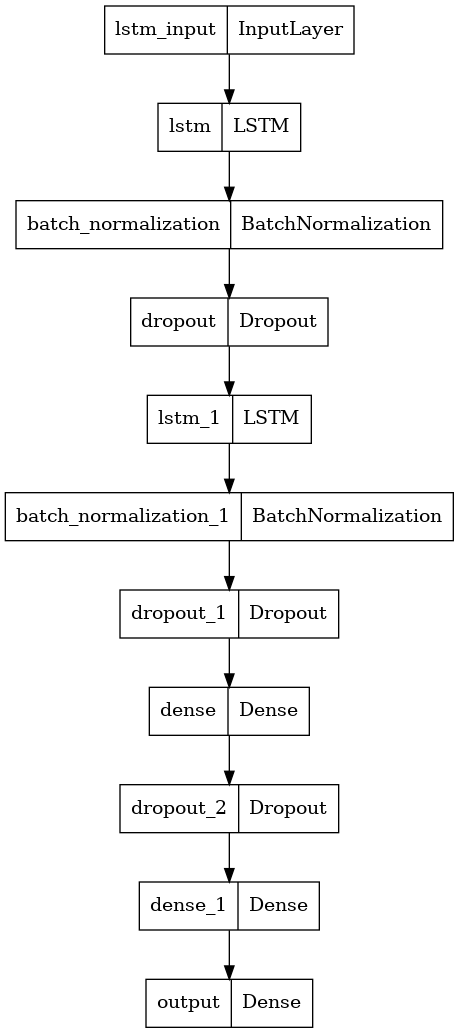

In [6]:
keras.utils.plot_model(model, to_file='model.png')

Create training set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=3141592)

Fit model

In [8]:
history = model.fit(X_train, y_train, batch_size=64, epochs=30, callbacks=[mc, es, rlr], validation_data=(X_test, y_test))

Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 0.7358 - binary_accuracy: 0.4648
Epoch 1: val_binary_accuracy improved from -inf to 0.51852, saving model to best_model.h5
4/4 [==============================] - 5s 374ms/step - loss: 0.7358 - binary_accuracy: 0.4648 - val_loss: 0.6939 - val_binary_accuracy: 0.5185 - lr: 0.0010
Epoch 2/30
1/4 [======>.......................] - ETA: 0s - loss: 0.7082 - binary_accuracy: 0.5156

/home/cubem10/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6849 - binary_accuracy: 0.5258
Epoch 2: val_binary_accuracy improved from 0.51852 to 0.64815, saving model to best_model.h5
4/4 [==============================] - 0s 102ms/step - loss: 0.6849 - binary_accuracy: 0.5258 - val_loss: 0.6825 - val_binary_accuracy: 0.6481 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 0.6727 - binary_accuracy: 0.5962
Epoch 3: val_binary_accuracy improved from 0.64815 to 0.72222, saving model to best_model.h5
4/4 [==============================] - 0s 98ms/step - loss: 0.6727 - binary_accuracy: 0.5962 - val_loss: 0.6783 - val_binary_accuracy: 0.7222 - lr: 0.0010
Epoch 4/30
4/4 [==============================] - ETA: 0s - loss: 0.6181 - binary_accuracy: 0.6432
Epoch 4: val_binary_accuracy did not improve from 0.72222
4/4 [==============================] - 0s 84ms/step - loss: 0.6181 - binary_accuracy: 0.6432 - val_loss: 0.6695 - val_binary_accuracy: 0.6852 - lr: 0.0010
Epoc

Evaluate model

In [9]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 21ms/step - loss: 0.0616 - binary_accuracy: 0.9815


[0.061588432639837265, 0.9814814925193787]

In [10]:
y_test_prob = model.predict(X_test, verbose=1)

2/2 [==============================] - 1s 18ms/step


In [11]:
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [13]:
confusion_matrix(y_test, y_test_pred)

array([[30,  1],
       [ 0, 23]])

In [14]:
y_pred = (y_test_prob > 0.5).astype('int32')
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.96      1.00      0.98        23

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



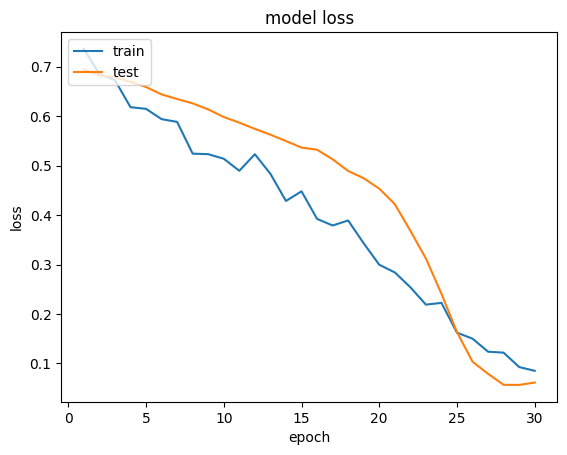

In [16]:
epochs = range(1, len(history.history['binary_accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()